![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import sys
!{sys.executable} -m conda install --yes py-xgboost

In [1]:
import warnings
warnings.filterwarnings('ignore')
#algo

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, auc, roc_curve, make_scorer



# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

 # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [6]:
# Celda 1
tree = tree_grow(X_train, y_train, level=0)
test_pred = tree_predict(X_test, tree, proba=False)
print("F1 score: ", f1_score(y_test, test_pred))
print("Accuracy: ", accuracy_score(y_test, test_pred))
print('Precision:', precision_score(y_test, test_pred))
print('Recall:', recall_score(y_test, test_pred))

F1 score:  0.8824242424242424
Accuracy:  0.8599884526558892
Precision: 0.8670795616960457
Recall: 0.8983218163869694


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2
np.random.seed(123)

n_samples =  data.shape[0]
print(n_samples)

n_B = 10
samples =  [np.random.choice(a=n_samples, size=n_samples, replace = True) for _ in range(1, n_B +1)]

samples

10495


[array([3582, 1346, 5218, ..., 3824, 2046, 2560]),
 array([1999, 4774,  173, ..., 5803,  742, 5039]),
 array([2114, 4003, 3565, ..., 2965,  679, 2539]),
 array([ 6265,  2062,  9901, ...,  8182,  8981, 10457]),
 array([ 1727,  9002, 10082, ...,  9627,  6818,  2533]),
 array([ 9342,  8135,  1731, ..., 10225,  1367,  9054]),
 array([10297,  4474,  4234, ..., 10043,  4228,  5067]),
 array([9836, 9902, 5024, ..., 1281, 3089, 3668]),
 array([ 4266,  6769, 10150, ...,  7107,  7829,  8145]),
 array([6838,   84, 6064, ..., 5539,  847, 9812])]

In [10]:
y_train.iloc[samples[0], :]

IndexError: positional indexers are out-of-bounds

In [11]:
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_test.iloc[sample, 1:]
    ytrain = X_train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

IndexError: positional indexers are out-of-bounds

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [12]:
# Celda 3


baglib = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                          max_features=int(np.log(len(X_train.columns))),bootstrap=True, 
                          oob_score=True, random_state=1)
baglib.fit(X_train, y_train)
y_pred = baglib.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))




F1 score:  0.8791666666666667
Accuracy:  0.8493071593533488
Precision: 0.8278116826503923
Recall: 0.937314906219151


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [15]:
# Celda 4
rfc =  RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

F1 score:  0.8671259842519685
Accuracy:  0.8441108545034642
Precision: 0.8645731108930323
Recall: 0.8696939782823297


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [16]:
# Celda 5 
feature_cols = data.columns[0:9]
feature_cols


estimator_range= range(10,310,10)
accuracy_scores= []
RMSE_scores = []
MSE_scores = []

for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators =estimator, random_state=1, n_jobs=-1 )
    accuracy_scores.append(cross_val_score(clf,X, y, cv=5, scoring='accuracy').mean())
    MSE_scores = cross_val_score(clf,X,y, cv=5, scoring='neg_mean_squared_error' )
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'Accuracy')

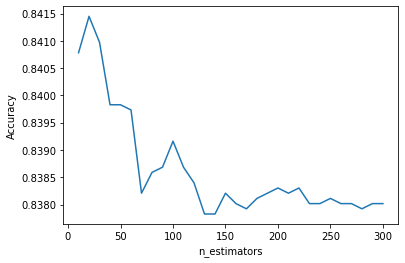

In [17]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')




Text(0, 0.5, 'RMSE')

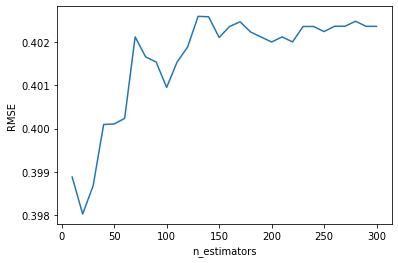

In [18]:
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [19]:
error, n_estimators = sorted(zip(RMSE_scores, estimator_range))[0]
(error, n_estimators)
                                                          

(0.39802489654962725, 20)

In [ ]:
clf = RandomForestClassifier(n_estimators=200, max_features=6, random_state=1, n_jobs=-1)
clf.fit(X, y)
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

In [ ]:
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [20]:
# Celda 6

clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

[12:49:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score:  0.9047160731472569
Accuracy:  0.8856812933025404
Precision: 0.8826291079812206
Recall: 0.9279368213228035


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
